# The Simpsons

## Preparations

### Import libraries

- Tensorflow: Machine Learning Library
- Matplotlib: Plotting (math) library

In [1]:
import tensorflow as tf
from matplotlib import image
from tensorflow.keras import datasets, layers, models, Sequential
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import glob
from sklearn import preprocessing, metrics

In [2]:
import warnings

#warnings.filterwarnings('ignore')

### Select Characters

Create a list of characters that we want to recognise

In [3]:
selected_characters = [
    "marge_simpson",
    "ned_flanders",
    "bart_simpson",
    "lisa_simpson",
    "principal_skinner",
    "sideshow_bob",
    "homer_simpson",
]

encoded_labels = preprocessing.LabelEncoder()
encoded_labels.fit(selected_characters)

LabelEncoder()

### Directories

In [4]:
directories = {
    "data_directory": "./data/archive/",
}

directories["annotation_file"] = directories["data_directory"] + "annotation.txt"
directories["dataset"] = directories["data_directory"] + "simpsons_dataset/"
directories["testset"] = directories["data_directory"] + "kaggle_simpson_testset/kaggle_simpson_testset/"

## Previewing the characters

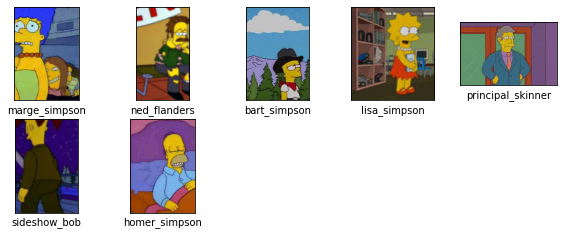

In [5]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = image.imread(directories["dataset"] + character_name + "/pic_0000.jpg")
    plt.imshow(img)
    plt.xlabel(character_name)
plt.show()

## Resizing Images
For testing this code creates the same as above but resized to the standard_resolution variable

In [6]:
standard_resolution = 352
resampling_algorithm = Image.LANCZOS  # todo decide on resampling algorithm

In [7]:
def get_resized_image(image_path):
    img = Image.open(image_path)
    img = img.resize(size=(standard_resolution, standard_resolution),
                     resample=resampling_algorithm)
    img = np.asarray(img)  #store im as numpy array
    # shape of image is ([128x(r,g,b)], [128x(r,g,b)])
    img = np.array(img)
    return img

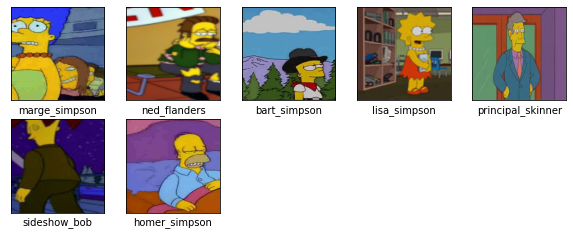

In [8]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(get_resized_image(directories["dataset"] + character_name + "/pic_0000.jpg"))
    plt.xlabel(character_name)
plt.show()

## Load files and split into test data

In [9]:
test_factor = 0.2  # determine what percentage of each character's images should be used for testing

In [10]:
training_images = []  # the images as rgb values
training_labels = []  # the corresponding character name

test_images = []  # the test images as rgb values
test_labels = []  # the corresponding character name

for character_name in selected_characters:  #loop over all selected characters

    current_character_path = directories["dataset"] + character_name + "/"
    current_character_paths_list = glob.glob(current_character_path + "*.jpg")

    # calculate how many files are test data and how many files are training data
    current_character_picture_count = len(current_character_paths_list)
    current_character_test_count = round(current_character_picture_count * test_factor)
    current_character_training_count = round(current_character_picture_count * (1 - test_factor))
    current_image_position = 0

    encoded_character_label = encoded_labels.transform([character_name])
    print("Loading Character:" + character_name + " (label number " + str(encoded_character_label[0]) + ")")
    print("", end='\n')

    for current_image_position, current_character_picture_path in enumerate(
            current_character_paths_list):  #loop over all files ending in .jpg in the current folder
        print("[", current_image_position, "/", current_character_picture_count, "]" + current_character_picture_path,
              end='\r')

        current_character_picture = get_resized_image(current_character_picture_path)  # load picture

        if current_image_position <= current_character_test_count:  # if the current image is still part of the test part add to testing
            test_images.append(current_character_picture)
            test_labels.append(encoded_character_label)
        else:
            training_images.append(current_character_picture)
            training_labels.append(encoded_character_label)
    print("", end='\n')

training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)
test_images = np.array(test_images)

Loading Character:marge_simpson (label number 3)

[ 1290 / 1291 ]./data/archive/simpsons_dataset/marge_simpson/pic_0743.jpg
Loading Character:ned_flanders (label number 4)

[ 1453 / 1454 ]./data/archive/simpsons_dataset/ned_flanders/pic_0743.jpg
Loading Character:bart_simpson (label number 0)

[ 1341 / 1342 ]./data/archive/simpsons_dataset/bart_simpson/pic_0743.jpg
Loading Character:lisa_simpson (label number 2)

[ 1353 / 1354 ]./data/archive/simpsons_dataset/lisa_simpson/pic_0743.jpg
Loading Character:principal_skinner (label number 5)

[ 1193 / 1194 ]./data/archive/simpsons_dataset/principal_skinner/pic_0743.jpg
Loading Character:sideshow_bob (label number 6)

[ 876 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0743.jpg
Loading Character:homer_simpson (label number 1)

[ 2245 / 2246 ]./data/archive/simpsons_dataset/homer_simpson/pic_2154.jpg


In [11]:
training_images[0].shape

(352, 352, 3)

## Create Convolutional Neuronal Network

In [12]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(standard_resolution, standard_resolution, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(selected_characters))
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 352, 352, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 352, 352, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 176, 176, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 88, 88, 64)        1

In [14]:
#from sklearn.preprocessing import LabelEncoder

#df[target_col] = LabelEncoder().fit_transform(df[target_col])

In [15]:
training_images, test_images = training_images / 255.0, test_images / 255.0

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # SparseCategoricalCrossentropy uses numbered labels instead of hot encoding (https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39)
    metrics=['accuracy']
)

history = model.fit(
    training_images, training_labels,
    epochs=10,
    validation_data=(test_images, test_labels)
)

2022-02-07 16:18:43.445119: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
244/244 [==============================] - 187s 762ms/step - loss: 1.9165 - accuracy: 0.2287 - val_loss: 1.9117 - val_accuracy: 0.2298
Epoch 2/10
244/244 [==============================] - 163s 668ms/step - loss: 1.9134 - accuracy: 0.2303 - val_loss: 1.9116 - val_accuracy: 0.2298
Epoch 3/10
244/244 [==============================] - 166s 681ms/step - loss: 1.9131 - accuracy: 0.2303 - val_loss: 1.9107 - val_accuracy: 0.2298
Epoch 4/10
244/244 [==============================] - 170s 695ms/step - loss: 1.9124 - accuracy: 0.2303 - val_loss: 1.9103 - val_accuracy: 0.2298
Epoch 5/10
244/244 [==============================] - 175s 715ms/step - loss: 1.9117 - accuracy: 0.2303 - val_loss: 1.9130 - val_accuracy: 0.2298
Epoch 6/10
244/244 [==============================] - 162s 665ms/step - loss: 1.9120 - accuracy: 0.2303 - val_loss: 1.9107 - val_accuracy: 0.2298
Epoch 7/10
244/244 [==============================] - 160s 655ms/step - loss: 1.9109 - accuracy: 0.2303 - val_loss: 1.9103 -

## Visualise the Network

62/62 - 10s - loss: 1.9103 - accuracy: 0.2298 - 10s/epoch - 163ms/step


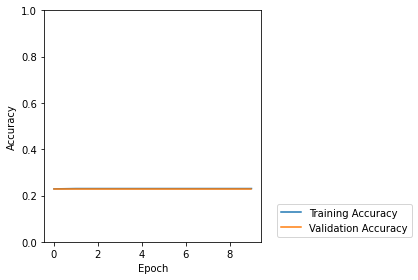

In [16]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("accuracy.png", dpi=300)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

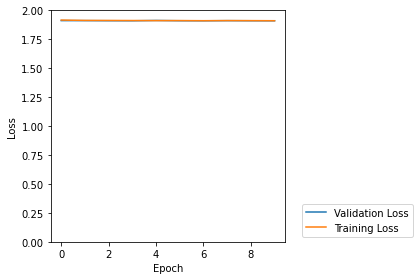

In [17]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("loss.png", dpi=300)

## Load the test dataset

In [18]:
def load_test_set():
    pics, labels = [], []
    for all_test_pictures in glob.glob(directories["testset"] + '*.jpg'):
        file_name = all_test_pictures.split("/")[-1] # './data/archive/kaggle_simpson_testset/kaggle_simpson_testset/principal_skinner_34.jpg'
        character_name_with_number = file_name.split(".jpg")[-2] # 'principal_skinner_34'
        character_name_clean = character_name_with_number.rsplit('_',1)[0] # 'principal_skinner'

        if character_name_clean in selected_characters:
            print(character_name_clean)
            character_label = encoded_labels.transform([character_name_clean])
            temp = get_resized_image(all_test_pictures)
            temp = temp / 255.0
            pics.append(temp)
            labels.append(character_label)
    x_test = np.array(pics)
    y_test = np.array(labels)
    print("Test set", x_test.shape, y_test.shape)
    return x_test, y_test

In [19]:
x_test, y_test = load_test_set()
prediction = model.predict(x_test)

principal_skinner
principal_skinner
sideshow_bob
sideshow_bob
ned_flanders
ned_flanders
homer_simpson
lisa_simpson
marge_simpson
marge_simpson
marge_simpson
marge_simpson
lisa_simpson
homer_simpson
ned_flanders
ned_flanders
sideshow_bob
sideshow_bob
principal_skinner
principal_skinner
principal_skinner
principal_skinner
sideshow_bob
sideshow_bob
sideshow_bob
lisa_simpson
ned_flanders
lisa_simpson
marge_simpson
marge_simpson
marge_simpson
marge_simpson
marge_simpson
marge_simpson
lisa_simpson
ned_flanders
sideshow_bob
lisa_simpson
sideshow_bob
sideshow_bob
principal_skinner
principal_skinner
principal_skinner
principal_skinner
sideshow_bob
sideshow_bob
ned_flanders
ned_flanders
lisa_simpson
bart_simpson
marge_simpson
marge_simpson
marge_simpson
marge_simpson
marge_simpson
marge_simpson
bart_simpson
lisa_simpson
ned_flanders
ned_flanders
sideshow_bob
principal_skinner
principal_skinner
principal_skinner
principal_skinner
principal_skinner
sideshow_bob
sideshow_bob
ned_flanders
ned_flande

## Confusion Matrix

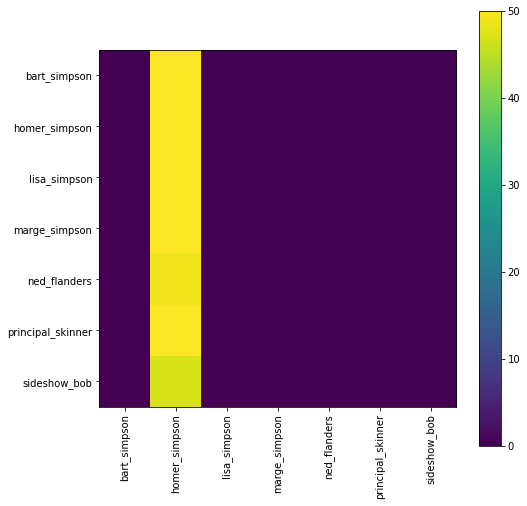

In [20]:
plt.figure(figsize=(8,8))
cnf_matrix = metrics.confusion_matrix(y_test, np.argmax(prediction, axis=1))
classes = list(encoded_labels.classes_)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)


## Simple Predictions

In [21]:
prediction_images = []

current_character_picture = get_resized_image(directories["testset"] + "bart_simpson_24.jpg")

im = current_character_picture / 255.0
img_array = tf.expand_dims(im, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions[0])
print(score)

#print(100 * np.max(score))

print(np.argmax(predictions))
#print([labels[i] for i,prob in enumerate(predictions) if prob > 0.5])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(encoded_labels.inverse_transform([np.argmax(score)])[0], 100 * np.max(score))
)

[-0.04972716  0.5248067  -0.01884399 -0.03726808  0.09946352 -0.12560923
 -0.41233832]
tf.Tensor(
[0.13151178 0.23360468 0.13563666 0.13316055 0.15267129 0.12190163
 0.09151339], shape=(7,), dtype=float32)
1
This image most likely belongs to homer_simpson with a 23.36 percent confidence.
